2.1 Images

In [ ]:
import random
import numpy as np
import torch
from torch.utils.data import Subset
from torchvision import datasets, transforms
from einops import rearrange
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

In [ ]:
transform = transforms.ToTensor()

mnist_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Randomized subset of 1000 images
subset_size = 1000
all_indices = torch.randperm(len(mnist_train))[:subset_size].tolist()
mnist_subset = Subset(mnist_train, all_indices)

print("Subset length:", len(mnist_subset))

# Checking if samples are in the required format
img0, y0 = mnist_subset[0]
print("Image shape:", img0.shape, "Label:", y0)

100%|██████████| 9.91M/9.91M [00:00<00:00, 40.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.12MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.9MB/s]

Subset length: 1000
Image shape: torch.Size([1, 28, 28]) Label: 8


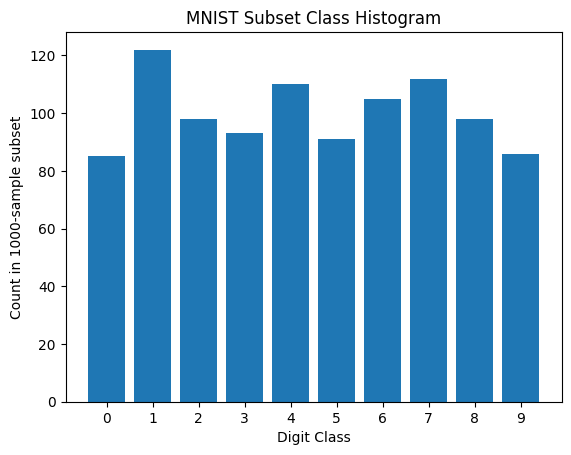

Counts per class: [85, 122, 98, 93, 110, 91, 105, 112, 98, 86]


In [ ]:
# Histogram of classes in MNIST
labels = []
for i in range(len(mnist_subset)):
    _, y = mnist_subset[i]
    labels.append(int(y))

labels = np.array(labels)
counts = np.bincount(labels, minlength=10)

plt.figure()
plt.bar(np.arange(10), counts)
plt.xticks(np.arange(10))
plt.xlabel("Digit Class")
plt.ylabel("Count in 1000-sample subset")
plt.title("MNIST Subset Class Histogram")
plt.show()

print("Counts per class:", counts.tolist())

In [ ]:
batch_size = 25

# Stack images into a single tensor of shape [1000, 1, 28, 28]
images = torch.stack([mnist_subset[i][0] for i in range(len(mnist_subset))], dim=0)
targets = torch.tensor([mnist_subset[i][1] for i in range(len(mnist_subset))])

print("Stacked images shape:", images.shape)   # [1000,1,28,28]
print("Targets shape:", targets.shape)         # [1000]

# We want: [NumBatches, BatchSize, 1, 28, 28]
# 1000 is divisible by 25 -> 40 batches
batched_images = rearrange(images, '(b s) c h w -> b s c h w', s=batch_size)
batched_targets = rearrange(targets, '(b s) -> b s', s=batch_size)

print("Batched images shape:", batched_images.shape)   # [40,25,1,28,28]
print("Batched targets shape:", batched_targets.shape) # [40,25]

Stacked images shape: torch.Size([1000, 1, 28, 28])
Targets shape: torch.Size([1000])
Batched images shape: torch.Size([40, 25, 1, 28, 28])
Batched targets shape: torch.Size([40, 25])


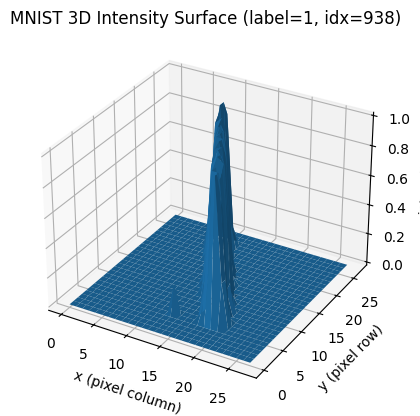

In [ ]:
idx = random.randrange(subset_size)
img = images[idx, 0].numpy()  # [28,28] (single channel)
label = int(targets[idx].item())

# Create meshgrid for pixel coordinates
x = np.arange(28)
y = np.arange(28)
X, Y = np.meshgrid(x, y)

Z = img  # pixel intensity in [0,1]

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Surface plot
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0)

ax.set_xlabel("x (pixel column)")
ax.set_ylabel("y (pixel row)")
ax.set_zlabel("intensity")
ax.set_title(f"MNIST 3D Intensity Surface (label={label}, idx={idx})")

plt.show()

2.2 Time Series

In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

uploaded = files.upload()

Saving energydata_complete.csv to energydata_complete.csv


In [ ]:
# Loading the CSV
# If you uploaded it in the previous cell:
csv_name = next(iter(uploaded.keys()))
df = pd.read_csv(io.BytesIO(uploaded[csv_name]))

print("Shape:", df.shape)
print(df.head())
print("\nColumns:\n", df.columns.tolist())

Shape: (19735, 29)
                  date  Appliances  lights     T1       RH_1    T2       RH_2  \
0  2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.790000   
1  2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.722500   
2  2016-01-11 17:20:00          50      30  19.89  46.300000  19.2  44.626667   
3  2016-01-11 17:30:00          50      40  19.89  46.066667  19.2  44.590000   
4  2016-01-11 17:40:00          60      40  19.89  46.333333  19.2  44.530000   

      T3       RH_3         T4  ...         T9   RH_9     T_out  Press_mm_hg  \
0  19.79  44.730000  19.000000  ...  17.033333  45.53  6.600000        733.5   
1  19.79  44.790000  19.000000  ...  17.066667  45.56  6.483333        733.6   
2  19.79  44.933333  18.926667  ...  17.000000  45.50  6.366667        733.7   
3  19.79  45.000000  18.890000  ...  17.000000  45.40  6.250000        733.8   
4  19.79  45.000000  18.890000  ...  17.000000  45.40  6.133333        733.9   

   RH_out  Wi

In [ ]:
# Common column name in this dataset is "date"
# If yours differs, change here.
date_col = "date"
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

df = df.dropna(subset=[date_col]).sort_values(date_col).reset_index(drop=True)

# Ensure numeric where expected (won't break if already numeric)
for col in ["Appliances", "Press_mm_Hg"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

print("Datetime range:", df[date_col].min(), "->", df[date_col].max())

Datetime range: 2016-01-11 17:00:00 -> 2016-05-27 18:00:00


Plot appliances consumption for whole period + zoom one week

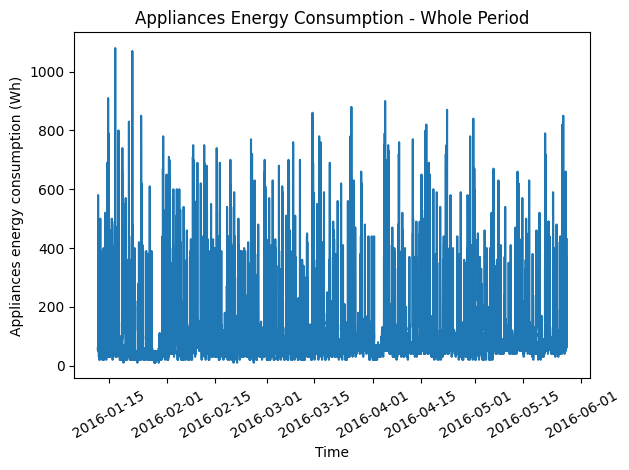

In [ ]:
if "Appliances" not in df.columns:
    raise ValueError("Column 'Appliances' not found. Check df.columns for the correct name.")

plt.figure()
plt.plot(df[date_col], df["Appliances"])
plt.xlabel("Time")
plt.ylabel("Appliances energy consumption (Wh)")
plt.title("Appliances Energy Consumption - Whole Period")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Week window: 2016-03-20 00:00:00 to 2016-03-27 00:00:00 | points: 1008


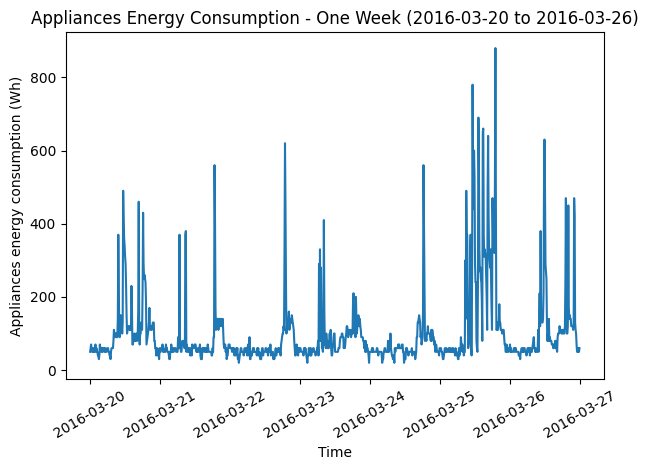

In [ ]:
# Pick a week start automatically near the middle to avoid edge issues
mid_time = df[date_col].iloc[len(df)//2]
week_start = (mid_time.floor("D"))
week_end = week_start + pd.Timedelta(days=7)

week_df = df[(df[date_col] >= week_start) & (df[date_col] < week_end)].copy()

print("Week window:", week_start, "to", week_end, "| points:", len(week_df))

plt.figure()
plt.plot(week_df[date_col], week_df["Appliances"])
plt.xlabel("Time")
plt.ylabel("Appliances energy consumption (Wh)")
plt.title(f"Appliances Energy Consumption - One Week ({week_start.date()} to {(week_end - pd.Timedelta(days=1)).date()})")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

Heatmap of hourly consumption for a week

/tmp/ipython-input-1875193261.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hourly = week_df["Appliances"].resample("1H").mean()


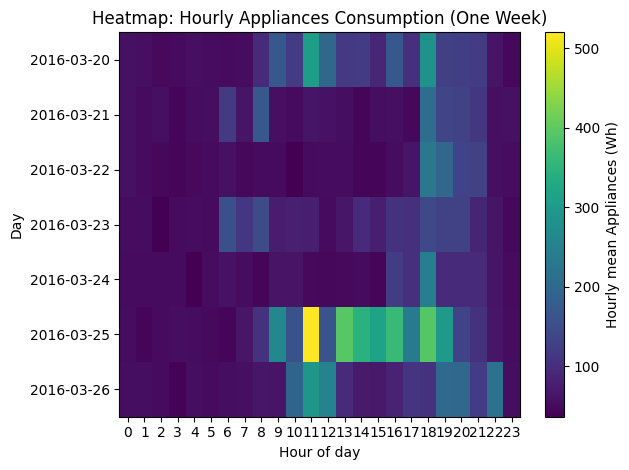

In [ ]:
# Create hourly averaged series for the chosen week
week_df = week_df.set_index(date_col)

hourly = week_df["Appliances"].resample("1H").mean()

# Build day x hour matrix
heat_df = hourly.to_frame("Appliances")
heat_df["day"] = heat_df.index.date
heat_df["hour"] = heat_df.index.hour

pivot = heat_df.pivot_table(index="day", columns="hour", values="Appliances", aggfunc="mean")

plt.figure()
plt.imshow(pivot.values, aspect="auto")
plt.colorbar(label="Hourly mean Appliances (Wh)")
plt.yticks(range(len(pivot.index)), [str(d) for d in pivot.index])
plt.xticks(range(24), range(24))
plt.xlabel("Hour of day")
plt.ylabel("Day")
plt.title("Heatmap: Hourly Appliances Consumption (One Week)")
plt.tight_layout()
plt.show()

Histogram

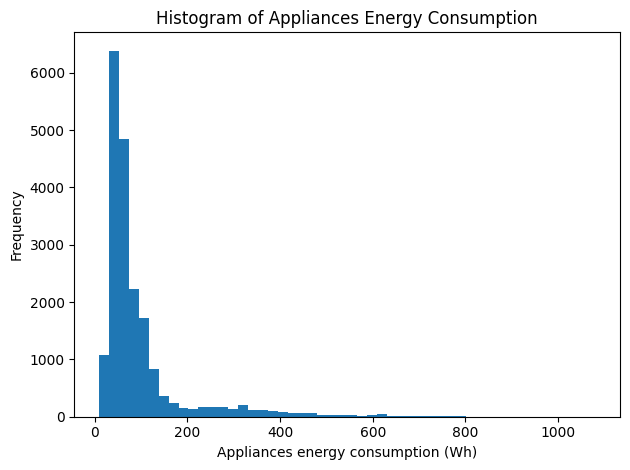

Appliances summary:
count    19735.000000
mean        97.694958
std        102.524891
min         10.000000
25%         50.000000
50%         60.000000
75%        100.000000
max       1080.000000
Name: Appliances, dtype: float64


In [ ]:
plt.figure()
plt.hist(df["Appliances"].dropna().values, bins=50)
plt.xlabel("Appliances energy consumption (Wh)")
plt.ylabel("Frequency")
plt.title("Histogram of Appliances Energy Consumption")
plt.tight_layout()
plt.show()

print("Appliances summary:")
print(df["Appliances"].describe())

Construct NSM (seconds from midnight) and plot energy vs NSM

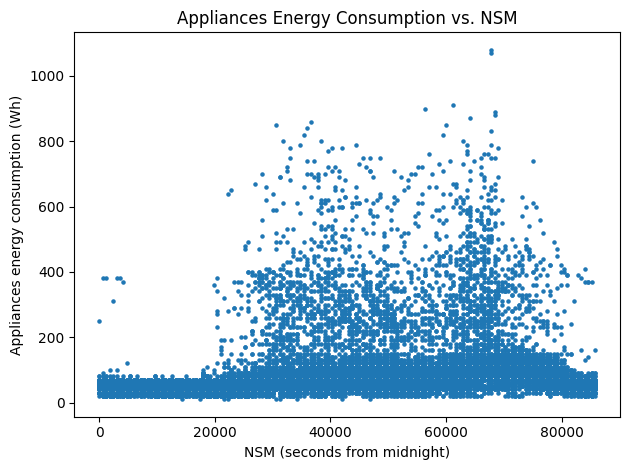

In [ ]:
# NSM: number of seconds from midnight for each timestamp
t = df[date_col]
nsm = (t.dt.hour * 3600) + (t.dt.minute * 60) + (t.dt.second)
df["NSM"] = nsm

plt.figure()
plt.scatter(df["NSM"], df["Appliances"], s=5)
plt.xlabel("NSM (seconds from midnight)")
plt.ylabel("Appliances energy consumption (Wh)")
plt.title("Appliances Energy Consumption vs. NSM")
plt.tight_layout()
plt.show()

Plot appliances vs Press_mm_Hg

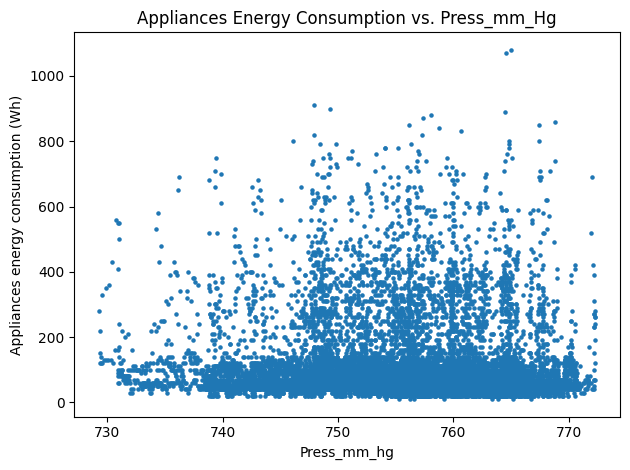

In [ ]:
if "Press_mm_hg" not in df.columns:
    raise ValueError("Column 'Press_mm_hg' not found. Check df.columns for the correct name.")

plt.figure()
plt.scatter(df["Press_mm_hg"], df["Appliances"], s=5)
plt.xlabel("Press_mm_hg")
plt.ylabel("Appliances energy consumption (Wh)")
plt.title("Appliances Energy Consumption vs. Press_mm_Hg")
plt.tight_layout()
plt.show()

Comment: why NSM and Press_mm_Hg are major contributors

2.3 Multi-variate

In [ ]:
from google.colab import files
import io
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis

uploaded = files.upload()

Saving AirfoilSelfNoise.csv to AirfoilSelfNoise.csv


In [ ]:

file_name = next(iter(uploaded.keys()))

df = pd.read_csv(
    io.BytesIO(uploaded[file_name]),
    sep=",",          # comma-separated
    header=0          # first row is header
)

print("Shape:", df.shape)
print(df.head())
print("\nColumns:\n", df.columns.tolist())

Shape: (1503, 6)
      f  alpha       c  U_infinity     delta     SSPL
0   800    0.0  0.3048        71.3  0.002663  126.201
1  1000    0.0  0.3048        71.3  0.002663  125.201
2  1250    0.0  0.3048        71.3  0.002663  125.951
3  1600    0.0  0.3048        71.3  0.002663  127.591
4  2000    0.0  0.3048        71.3  0.002663  127.461

Columns:
 ['f', 'alpha', 'c', 'U_infinity', 'delta', 'SSPL']


In [ ]:
stats_df = pd.DataFrame(index=df.columns)

# Mean
stats_df["Mean"] = df.mean()

# Variance
stats_df["Variance"] = df.var()

# Standard Deviation
stats_df["Std_Dev"] = df.std()

# Median
stats_df["Median"] = df.median()

# Kurtosis
stats_df["Kurtosis"] = df.apply(lambda x: kurtosis(x, bias=False))

# Skewness
stats_df["Skewness"] = df.apply(lambda x: skew(x, bias=False))

# Range
stats_df["Range"] = df.max() - df.min()

stats_df

,Mean,Variance,Std_Dev,Median,Kurtosis,Skewness,Range
f,2886.380572,9.938717e+06,3152.573137,1600.000000,5.708685,2.137084,19800.000000
alpha,6.782302,3.502424e+01,5.918128,5.400000,-0.412951,0.689164,22.200000
c,0.136548,8.749868e-03,0.093541,0.101600,-1.037964,0.457457,0.279400
U_infinity,50.860745,2.425116e+02,15.572784,39.600000,-1.563951,0.235852,39.600000
delta,0.011140,1.729287e-04,0.013150,0.004957,2.218903,1.702165,0.058011
SSPL,124.835943,4.759146e+01,6.898657,125.721000,-0.314187,-0.418952,37.607000


3.1 Image pre-processing and transformation

3.2 Image Segmentation